In [1]:
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import re

def spellProcessor(word):
    word = word.lower()
    word = word.replace("gyftis", "gifts")
    word = word.replace("gether", "gather")
    word = word.replace("spirituall", "spiritual")
    word = word.replace("feythfull", "faith")
    word = word.replace("wytnes", "witness")
    word = word.replace("almes", "alms")
    word = word.replace("desyre", "desire")
    word = word.replace("selfe", "self")
    word = word.replace("saffely", "safely")
    word = word.replace("realme", "realm")
    word = word.replace("acte", "act")
    word = word.replace("fourme", "form")
    word = word.replace("subiectes", "subjects")
    word = word.replace("theyr", "their")
    word = word.replace("kynde", "kind")
    word = word.replace("kynge", "king")
    word = word.replace("kyndes", "kinds")
    word = word.replace("vpon", "unto")
    word = word.replace("purueyours", "purveyors")
    word = word.replace("highnes", "highness")
    word = word.replace("euery", "every")
    word = word.replace("quene", "queen")
    word = word.replace("quenes", "queens")
    word = word.replace("whiche", "which")
    word = word.replace("bloude", "blood")
    word = word.replace("soueraine", "sovereign")
    word = word.replace("enactd", "enacted")
    word = word.replace("vs", "us")
    
    # replace digits
    tmp = list()
    for w in word.split():
        w = re.sub('\d','', w)
        tmp.append(w)
    word = ' '.join(tmp)

    return word

stopWords = [",","the","and","of","or","to","in","shall","be","that","any","by",".",
              "such","as","this","for","same","all","said","other","'s",";",
              "her","is","every","[","]","they","within", "our", "not", "so",
              "made", "no", "then", ":", "do", "from", "if", "it", "which", "at", "with",
             "thereof","upon", "a", "because", "used", "some", "but", "aforesaid", "also",
             ")","(", "what", "&", "may", "are", "their", "them", "sayde", "suche", "shalbe", "anye", "sayd",
             "thesaid", "/", "...", "/", "either", "haue", "vnto", "thy", "did", "was", "were", "have", "thee", 
             "your", "thou", "unto", "hath", "had", "went"]

In [2]:
input_data = list()
row_count = 0

metadata=list()
with open('../texts/textMetadata.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # deal with the header
        if row_count != 0:
            metadata.append(row)   
        row_count += 1
print("read",row_count,"lines")

read 46 lines


In [3]:
metadata[0]

['crown/RoyalProclamation_HenryVIII_1520.txt',
 'Royal Proclamation',
 '1520',
 'Henry VIII',
 'Crown']

In [4]:
labels = [i[4] for i in metadata]
files = list()
for i in metadata:
    fn = "../texts/" + i[0]
    files.append(fn)
    
vectorizer = CountVectorizer(
    input='filename',
    lowercase=True,
    ngram_range=(1,3),
    strip_accents=None, preprocessor=spellProcessor, stop_words=stopWords)

In [5]:
# get document term matrix
dtm = vectorizer.fit_transform(files)

# convert to tf-idf frequencies (to account for differences in text lengths)
tfidf_transformer = TfidfTransformer()
dtm_tfidf = tfidf_transformer.fit_transform(dtm)

In [6]:
# attempt to deal with imbalanced dataset

for c in set(labels):
    print("Class: {0}, Documents: {1}".format(c,labels.count(c)))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                     np.unique(labels),
                                     labels)

Class: Crown, Documents: 25
Class: People, Documents: 14
Class: Church, Documents: 6


In [7]:
# create and fit model using Support Vector Machine (SVM)
clf = SGDClassifier(tol=None,class_weight="balanced",max_iter=1000).fit(dtm_tfidf, labels)

In [8]:
# this function will return total count of a term in the vocabulary
def get_counts(term):
    widx = vectorizer.vocabulary_[term]
    return(vocab_sums[0,widx])

In [9]:
# what are our top terms?
vocab_sums = dtm.sum(axis=0)
sorted_vocab = [(v, vocab_sums[0, i]) for v, i in vectorizer.vocabulary_.items()]
sorted_vocab = sorted(sorted_vocab, key = lambda x: x[1], reverse=True)

# display top twenty words
for i in range(1,20):
    print(sorted_vocab[i][0],"->",sorted_vocab[i][1])

his -> 12166
lord -> 10214
him -> 8598
god -> 6284
my -> 6116
will -> 4954
me -> 4904
ye -> 4613
day -> 4424
when -> 3942
man -> 3886
king -> 3656
out -> 3494
we -> 3476
there -> 3381
on -> 3266
you -> 3201
men -> 3173
one -> 3154


In [28]:
# produce key features for each class
feature_names = vectorizer.get_feature_names()
feature_list=dict()

for cn, cl in enumerate(clf.classes_):
    terms = np.argsort(clf.coef_[cn])
    values = clf.coef_[cn].ravel()[np.argsort(clf.coef_[cn].ravel())]
    print("Key features for {}:".format(cl))
    feature_list[cl] = list()
    for i, t in enumerate(terms):
        # reverse sign
        v = -np.round(values[i],3)
        feature_list[cl].append((feature_names[t],v))
        if i < 50:
            print("{0} ({1})".format(feature_names[t],v),end=", ")
    print("\n")

Key features for Church:
we (0.367), these (0.238), thomist (0.232), foundation (0.224), rome (0.223), these men (0.193), pope (0.189), faith (0.18), has (0.164), fathers (0.16), sermon (0.159), master (0.156), men (0.152), authority (0.148), bishops (0.148), ther (0.144), christian (0.144), thomas (0.143), why (0.137), deny (0.136), articles (0.135), how (0.135), church rome (0.132), realm (0.131), than (0.128), sir (0.123), apostles (0.121), does (0.12), jackman (0.12), saith (0.119), his sermon (0.117), mastership (0.117), would (0.117), words (0.115), doctrine (0.113), paul (0.113), ought (0.111), religion (0.11), think (0.109), been (0.109), should (0.108), act (0.108), write (0.107), scriptures (0.106), though (0.106), london (0.104), directly (0.104), error (0.104), foundation faith (0.102), see (0.102), 

Key features for Crown:
he (1.187), my (0.922), him (0.681), john (0.552), kl (0.517), christ (0.509), me (0.457), kl kl (0.453), kl kl kl (0.423), saint (0.377), rom (0.368),

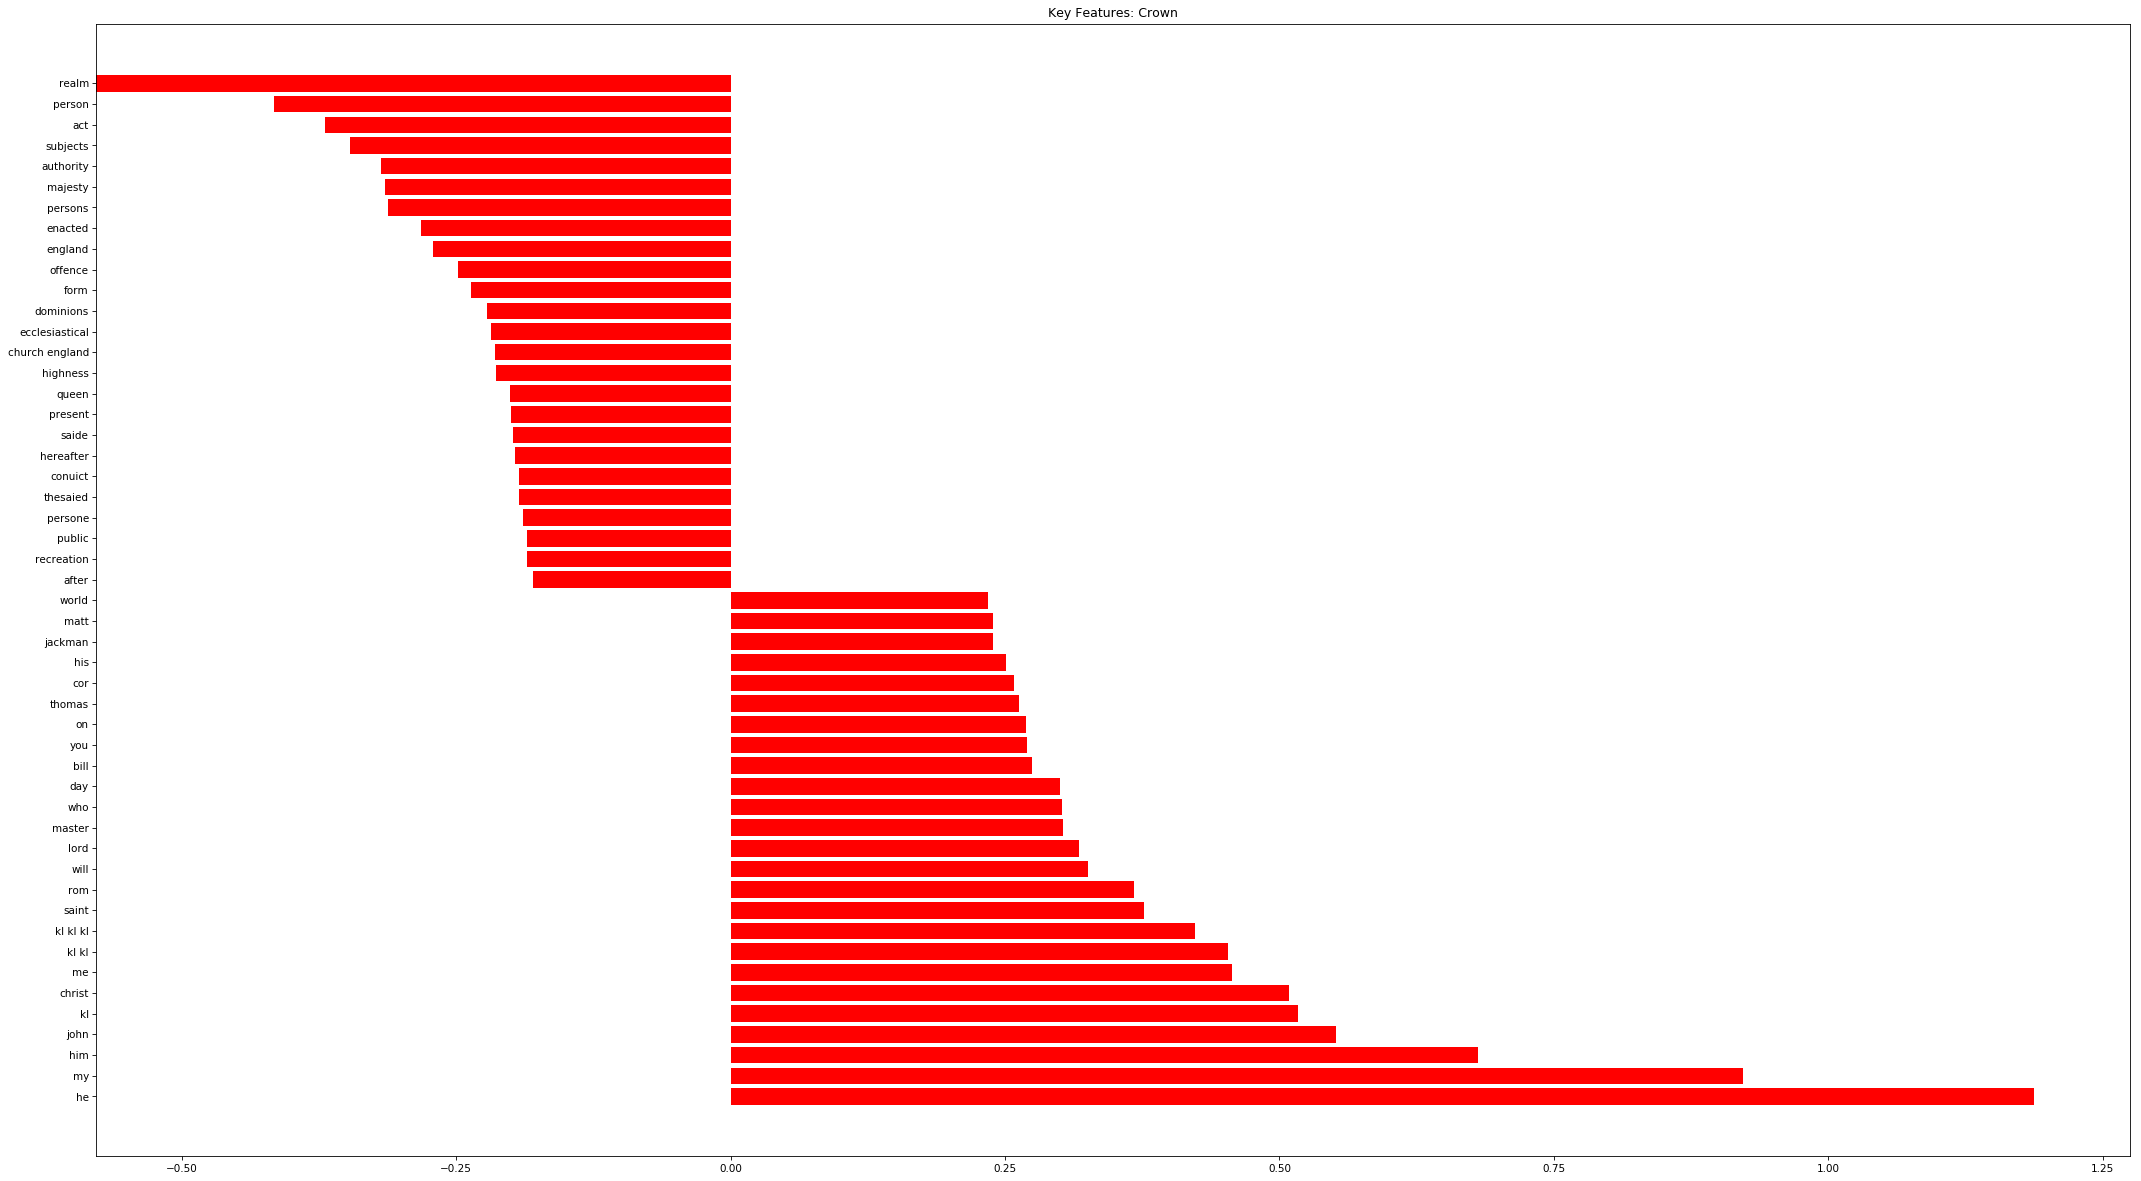

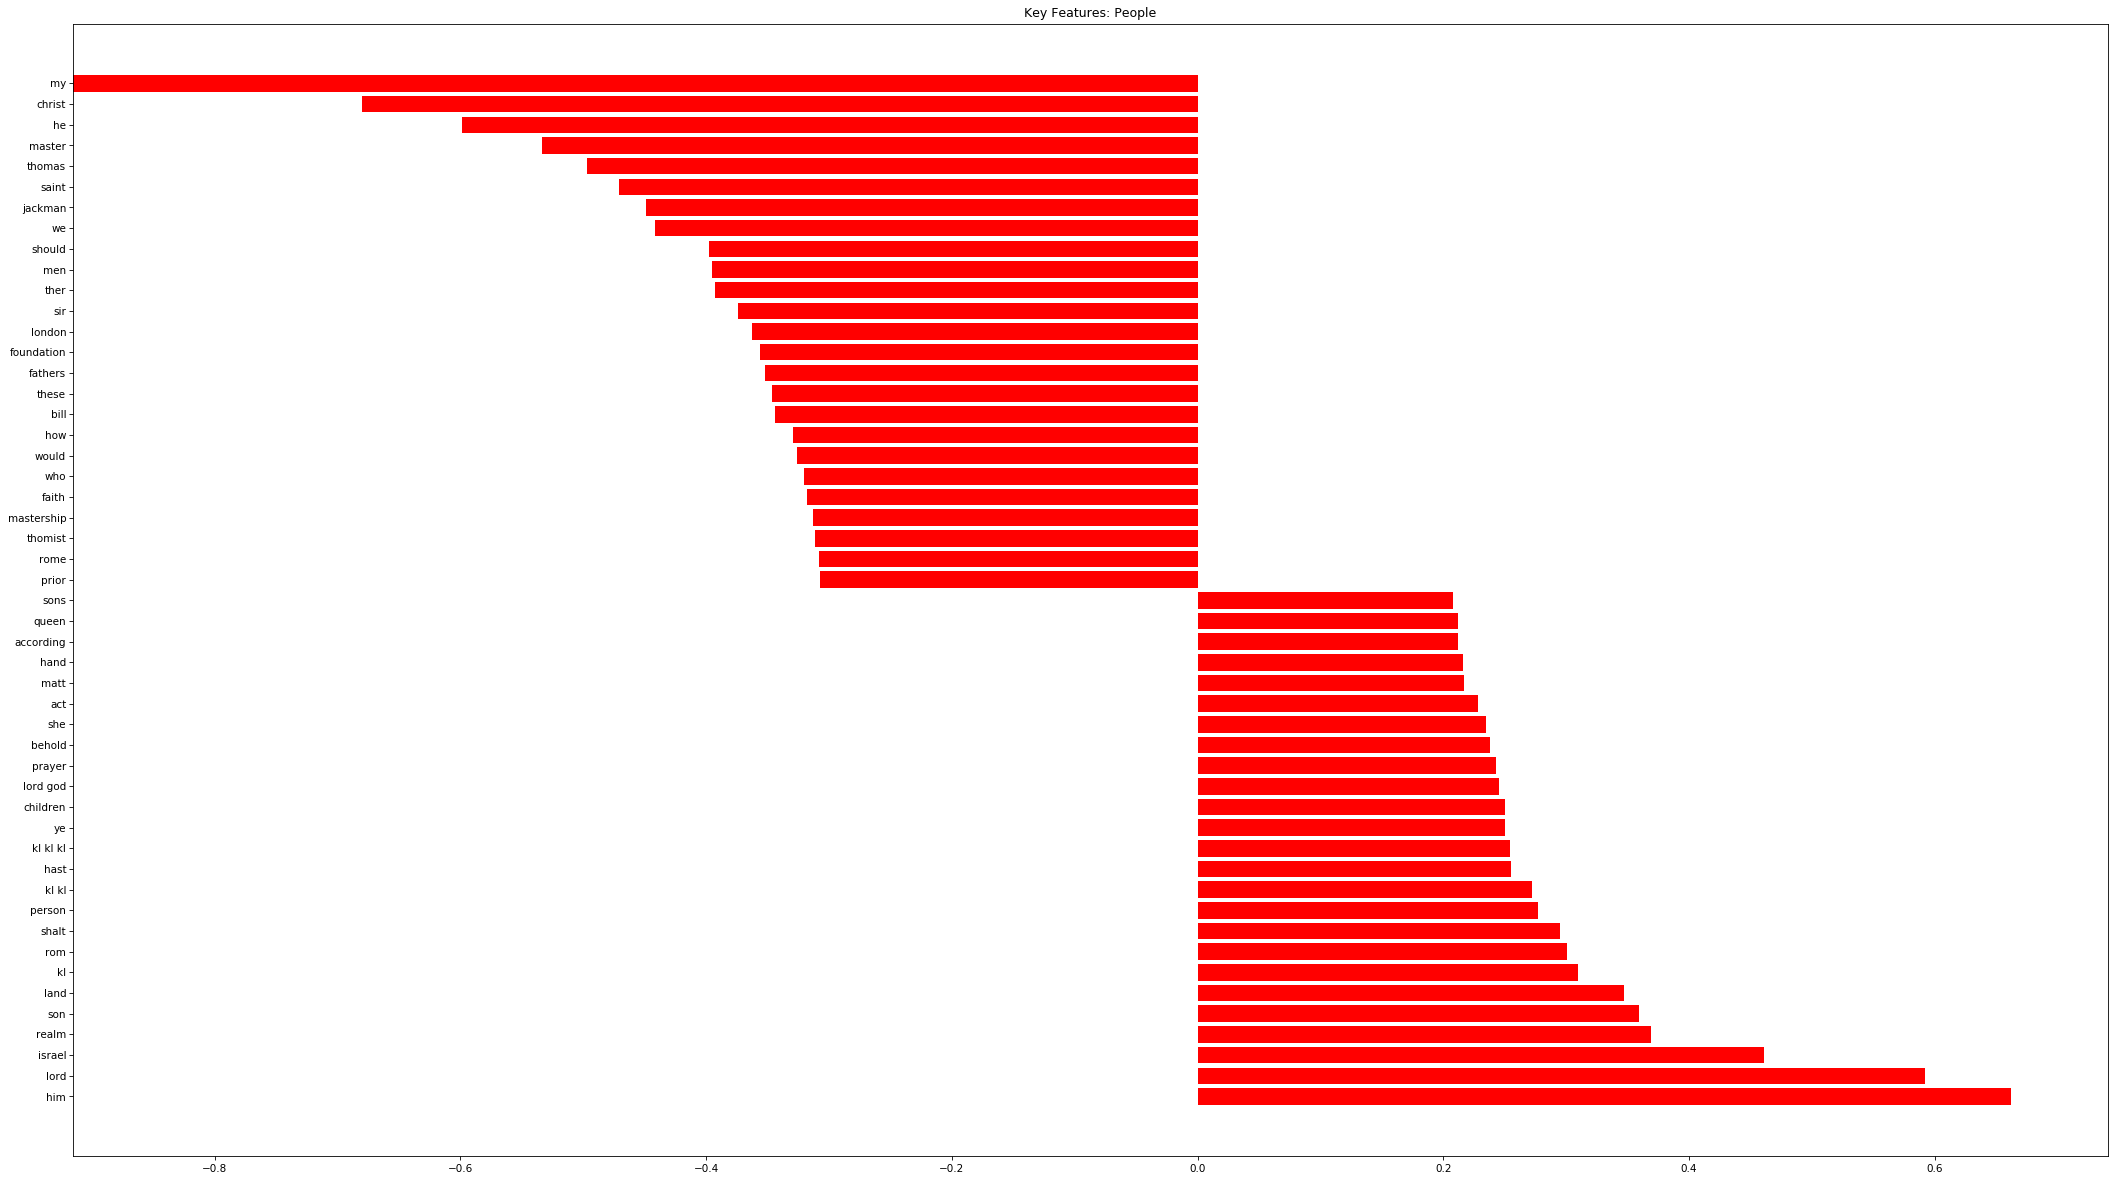

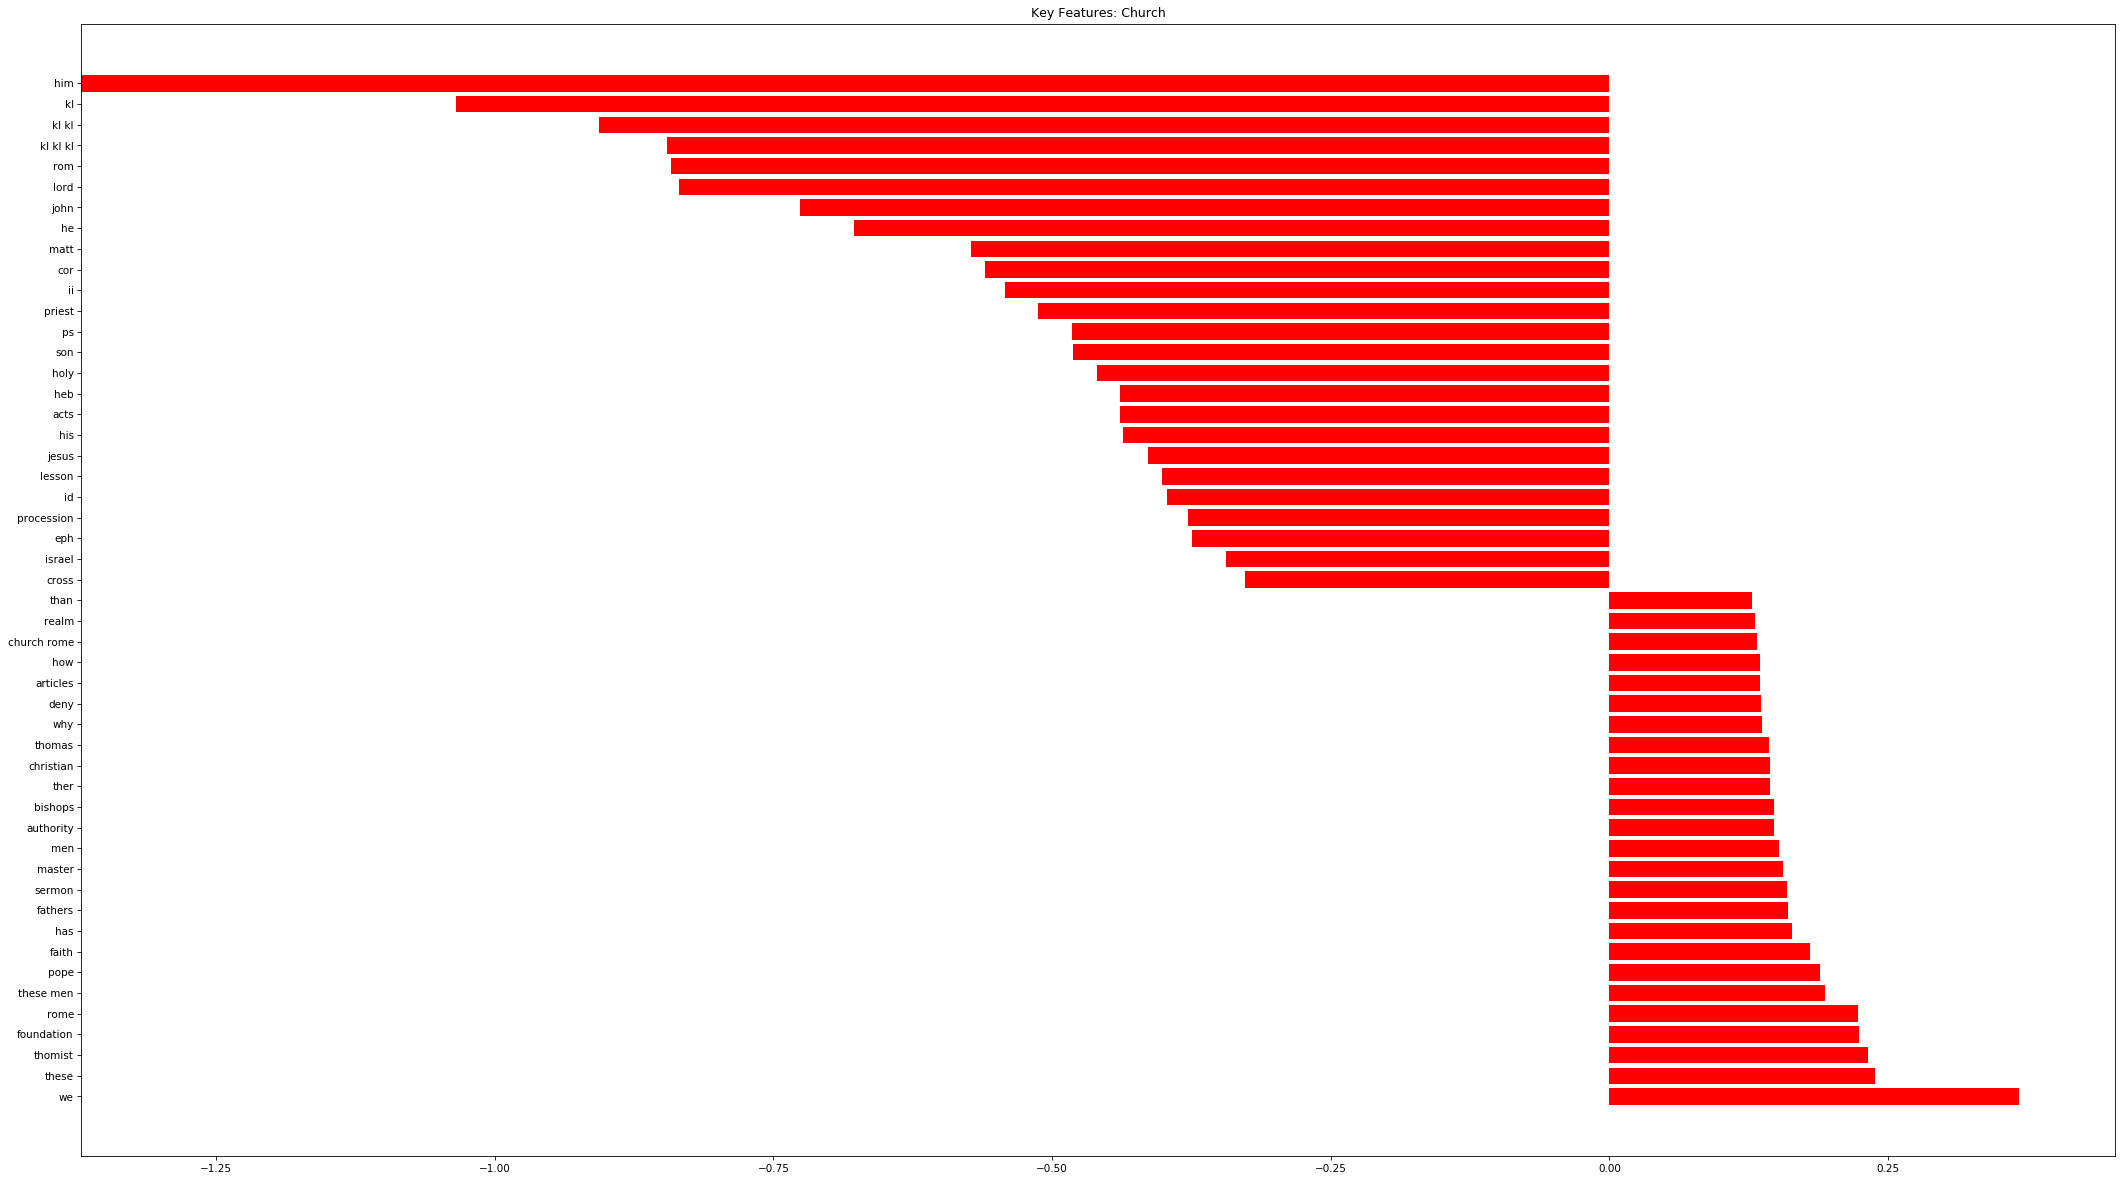

In [30]:
# reduce data
word_cloud_data=dict()
for cl in feature_list.keys():
    viz_words = feature_list[cl][:25] + feature_list[cl][-25:]
    word_cloud_data[cl] = dict()
    for i in feature_list[cl][:100]:
        word_cloud_data[cl][i[0]] = float(i[1])
        
    values = [x[1] for x in viz_words]
    kwords = [x[0] for x in viz_words]
    y_pos = range(len(values))

    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(35, 20), dpi=75)
    plt.barh(y_pos, values, align='center',tick_label=kwords,color="red")
    plt.title("Key Features: {0}".format(cl))
    plt.show()

Class: Crown


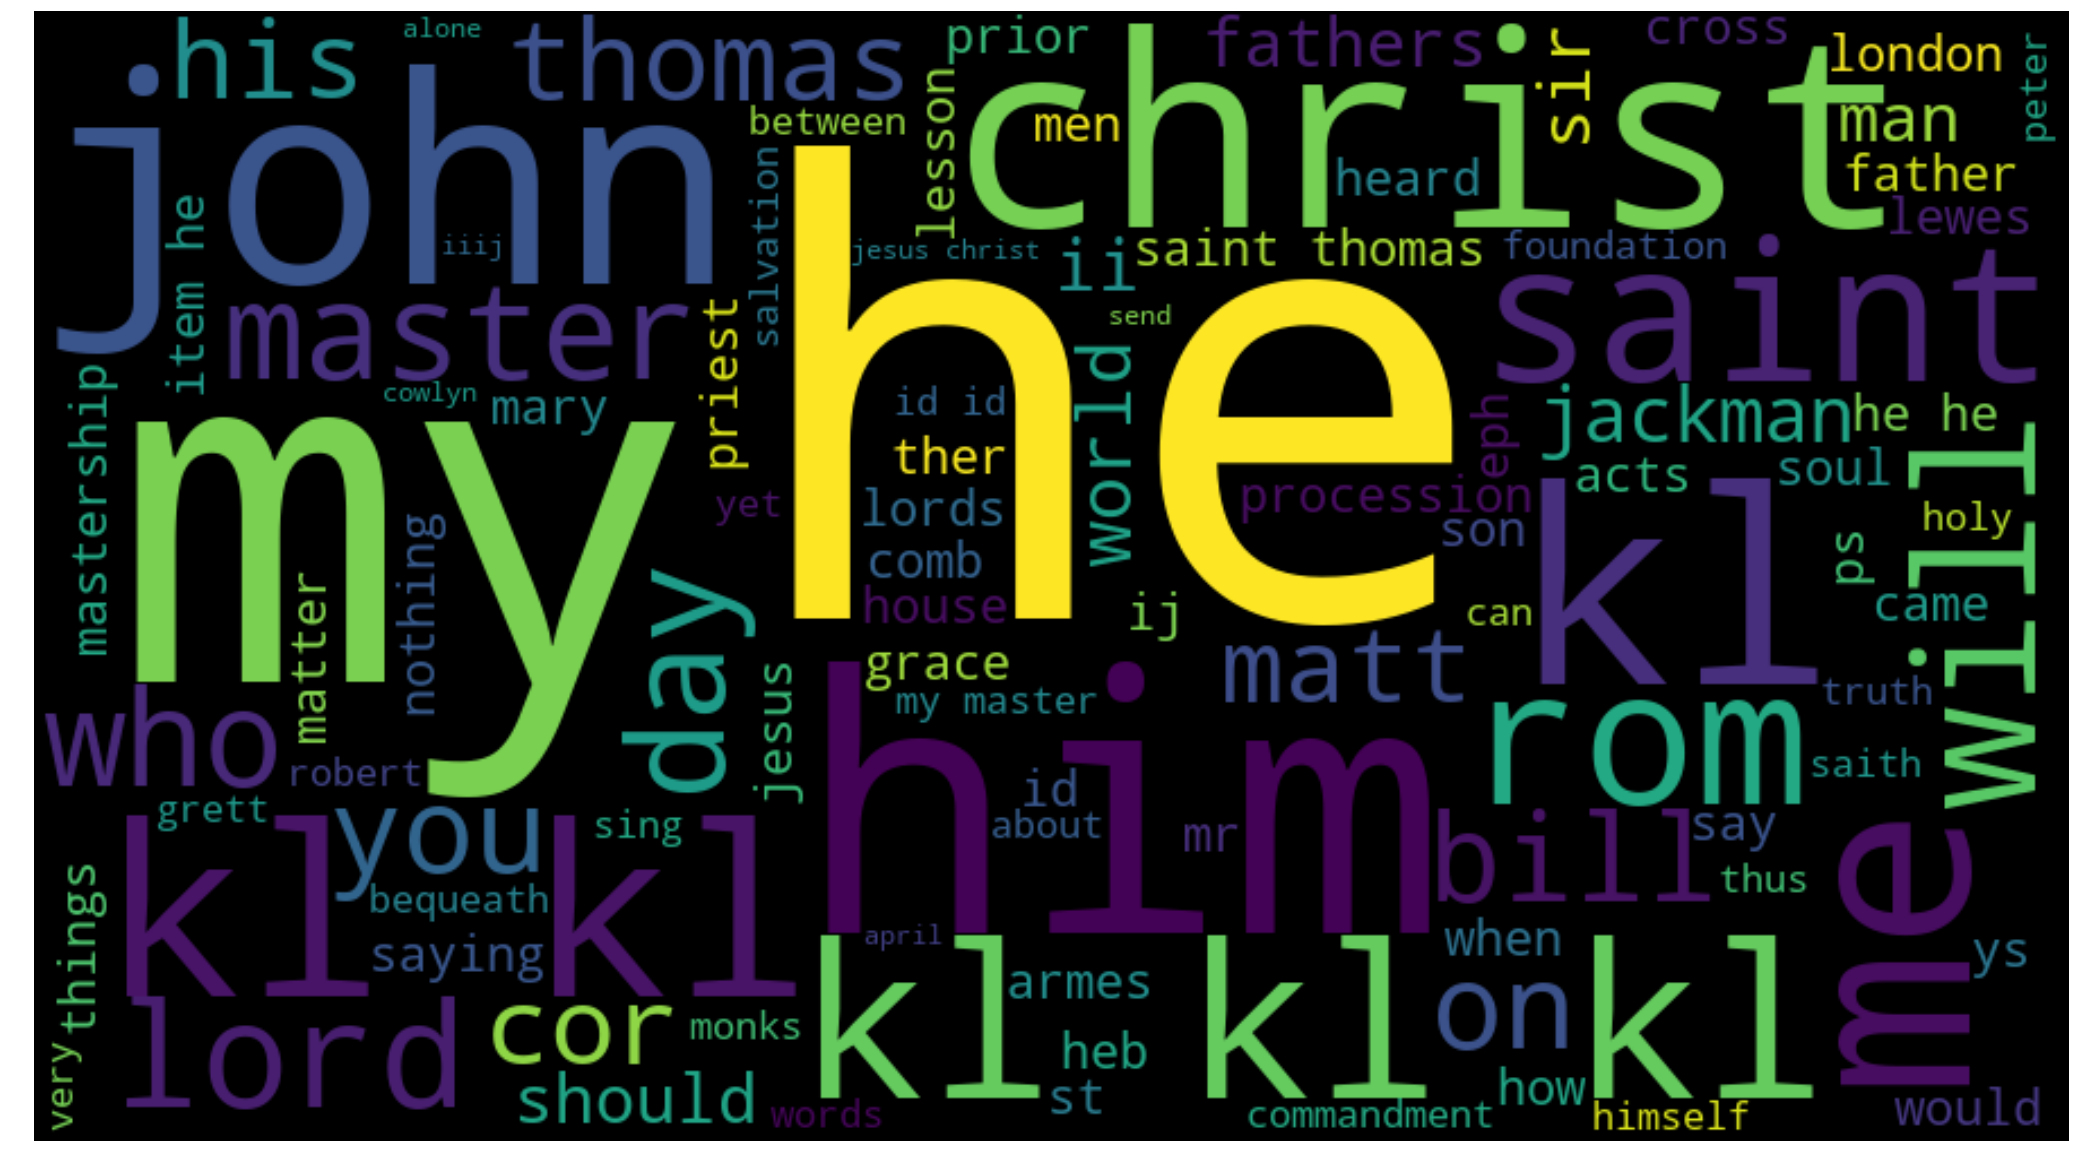

Class: People


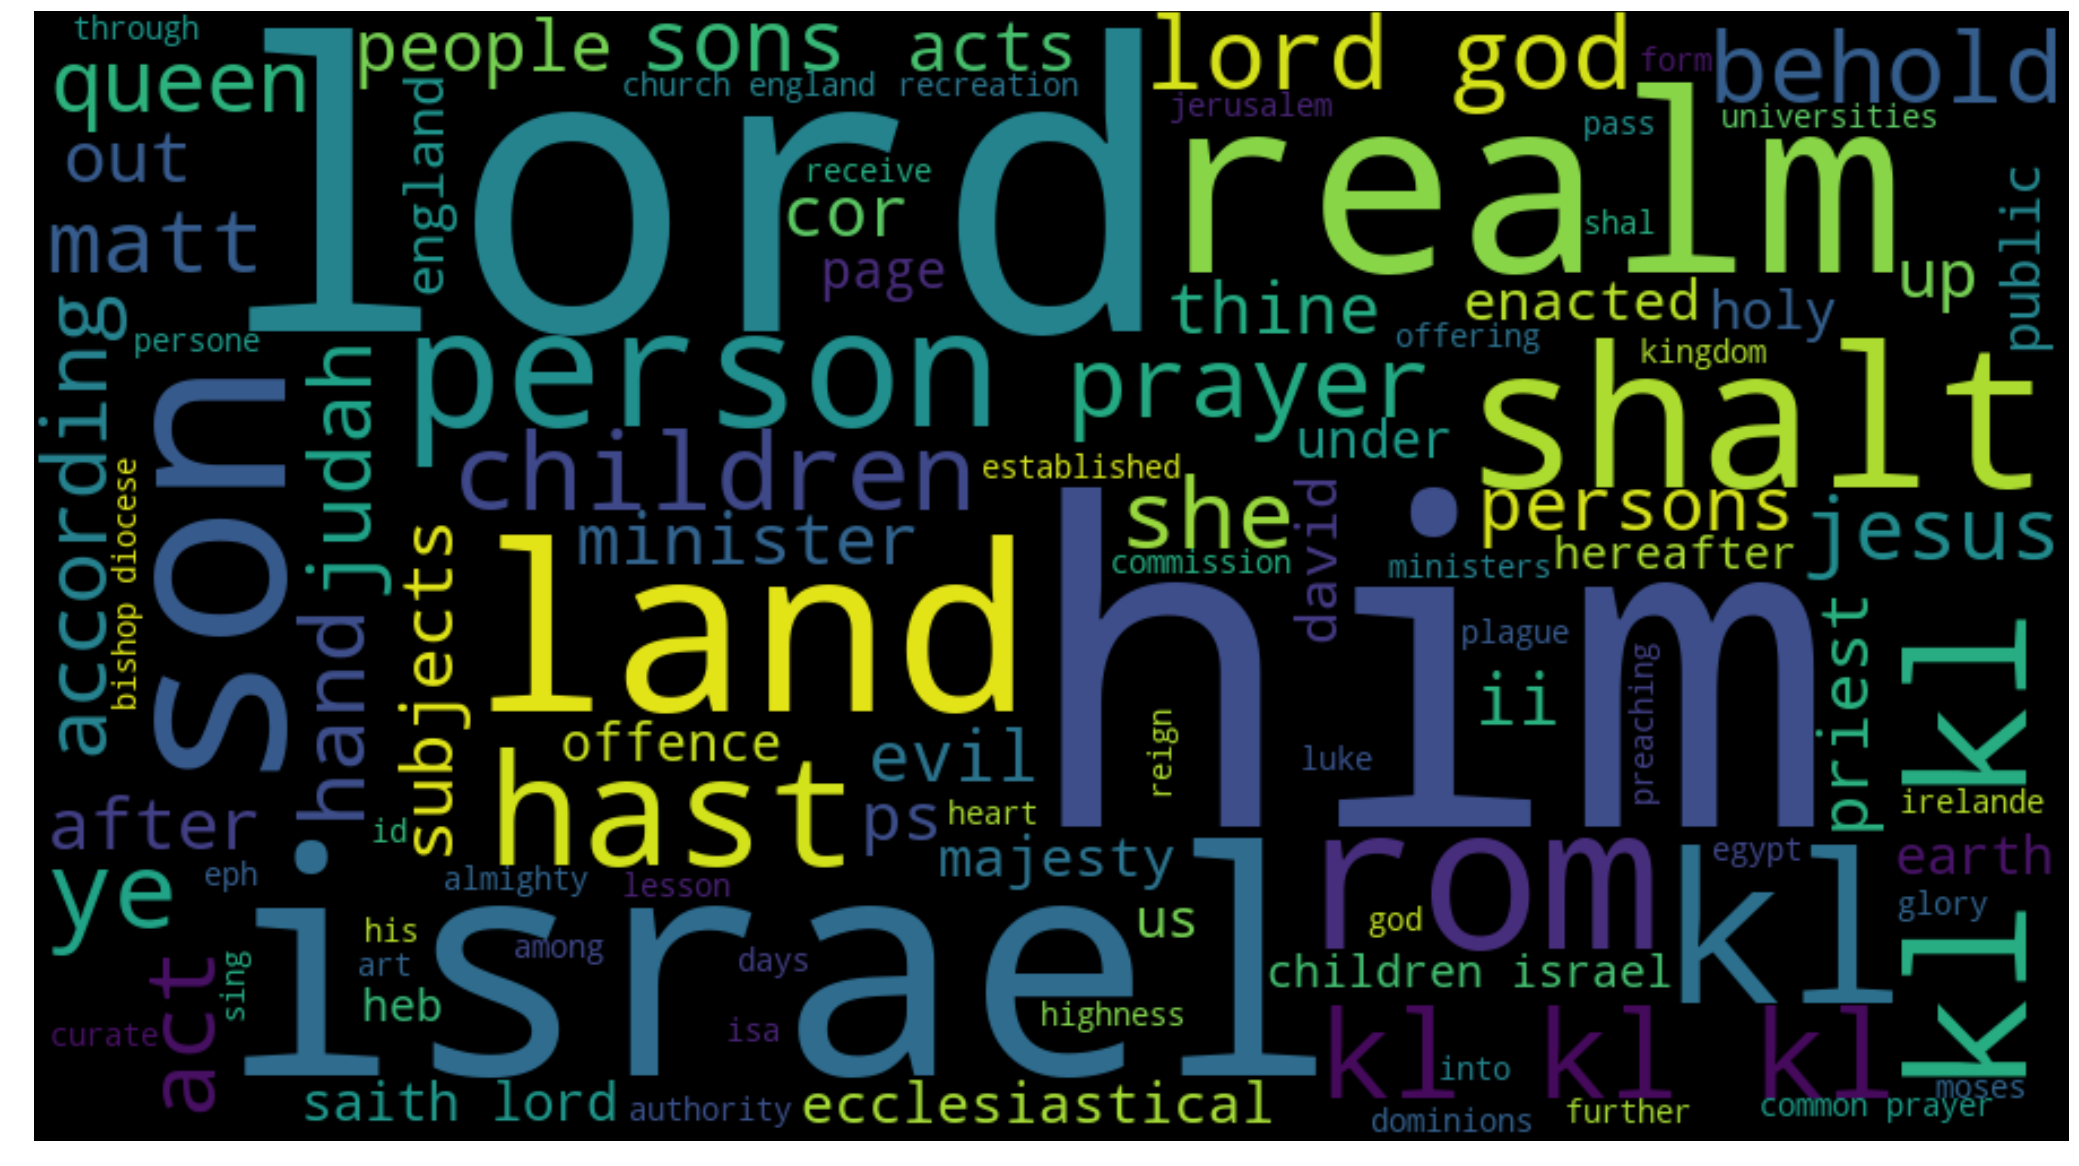

Class: Church


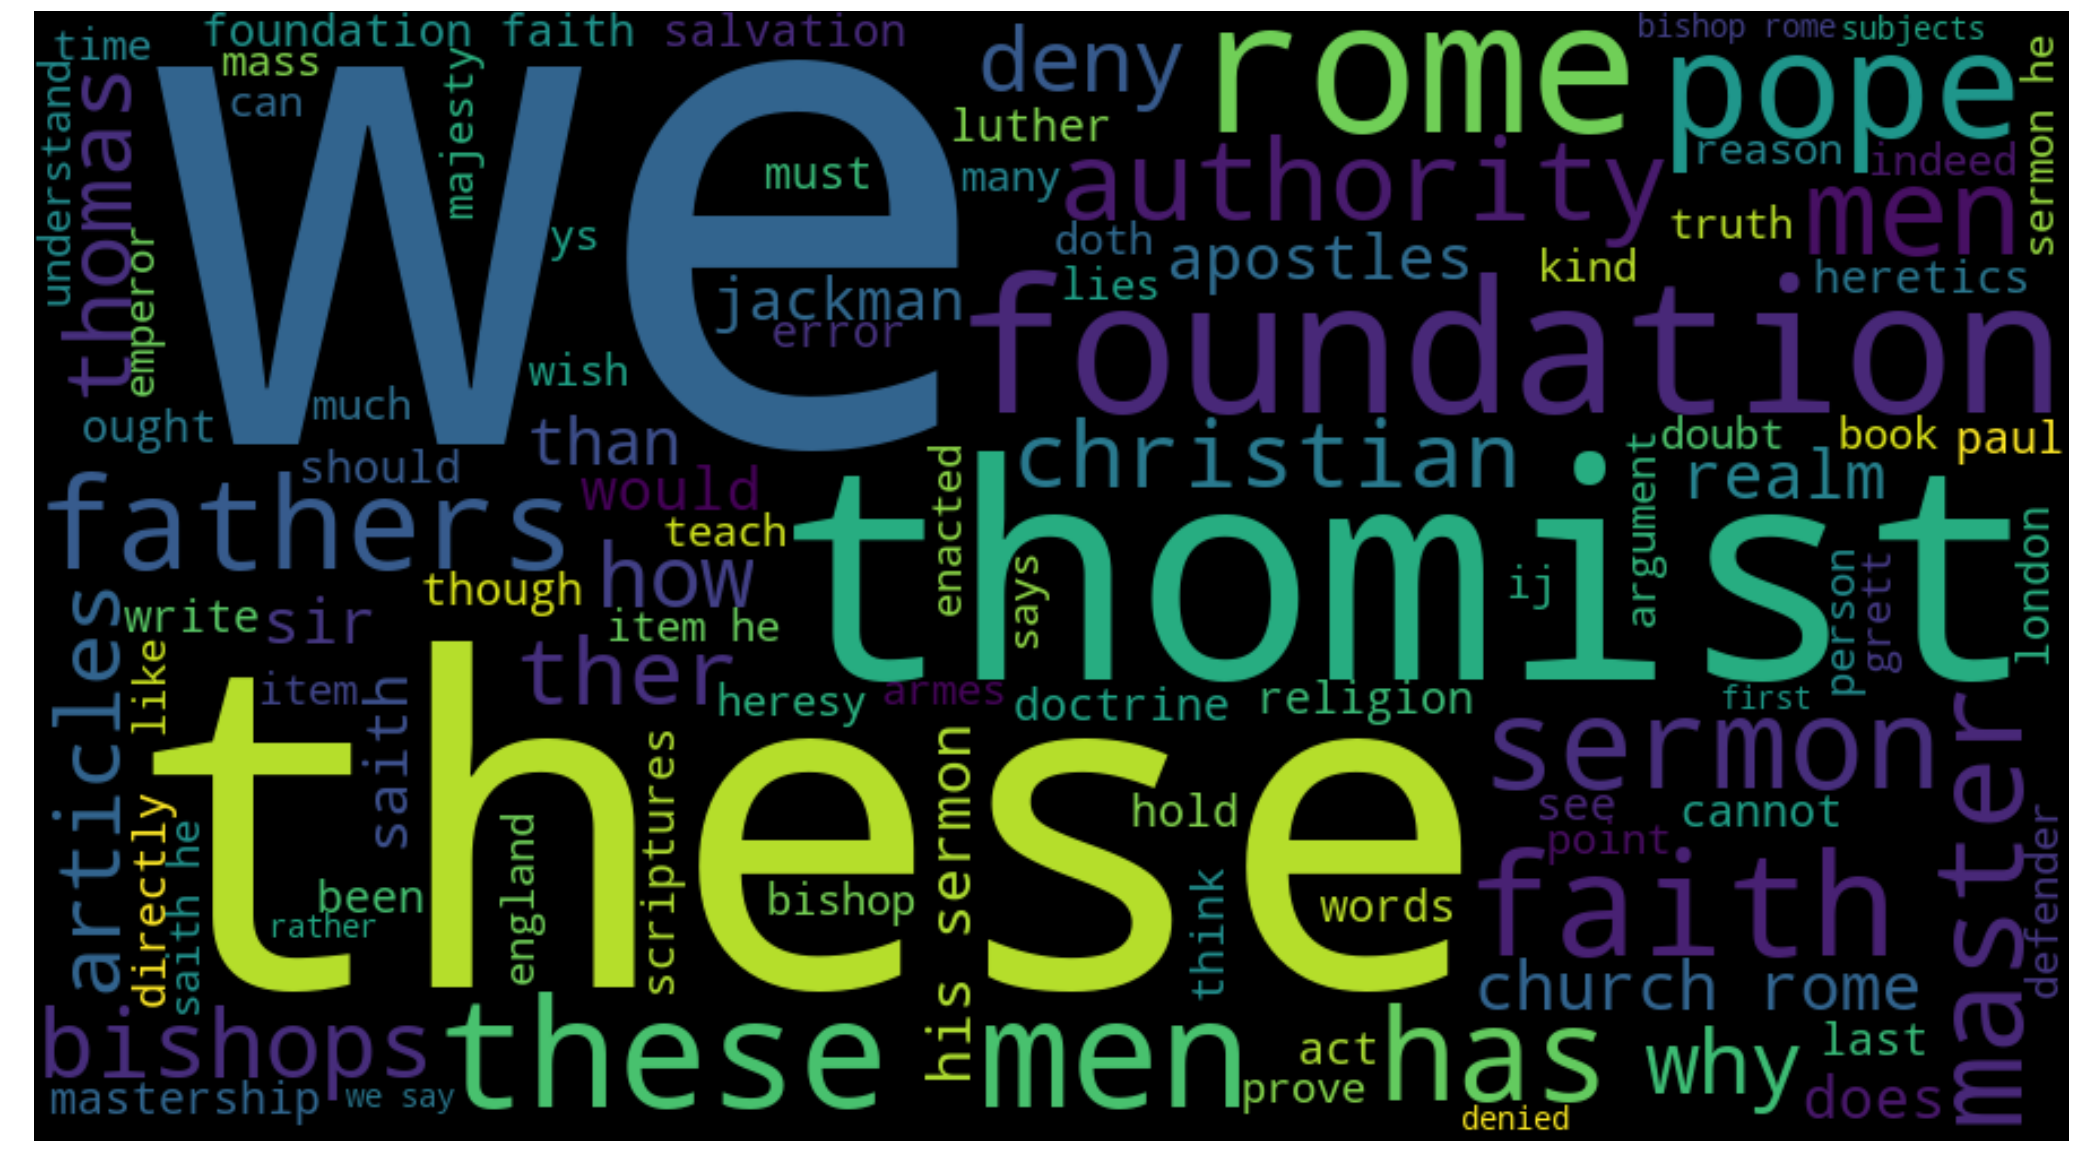

In [32]:
from wordcloud import WordCloud

# show most important features for each class:
for cl in word_cloud_data.keys():
    print("Class: {0}".format(cl))
    fig = plt.figure(figsize=(35, 20), dpi=75)
    wordcloud = WordCloud(width=900,height=500, max_words=1000,
                      relative_scaling=1).generate_from_frequencies(word_cloud_data[cl])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()